In [49]:
# Import the required libraries and dependencies
import pandas as pd
import requests
import json
import datetime as dt
import numpy as np
from prophet import Prophet
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holoviews as hv
import hvplot.pandas
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [50]:
# Get OINCX ticker information
OINCX = yf.Ticker("OINCX")

# Get closing historical prces for BTC-USD 
OINCX_df = OINCX.history(period="1d", start="2020-3-1", end="2023-7-10")[["Close"]]
OINCX_df.rename(columns={'Close': 'oincx'}, inplace=True)
OINCX_df.index = pd.bdate_range(start='2020-3-1', periods=844)
display(OINCX_df.head())
display(OINCX_df.tail())

,oincx
2020-03-02,16.076044
2020-03-03,15.676928
2020-03-04,16.317373
2020-03-05,15.788311
2020-03-06,15.519135


,oincx
2023-05-19,21.350000
2023-05-22,21.410000
2023-05-23,21.320000
2023-05-24,21.110001
2023-05-25,21.059999


In [51]:
trading_df = OINCX_df

In [52]:
trading_df.rename(columns={'oincx': 'Close'}, inplace=True)


In [53]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df['Close'].pct_change()

# Display sample data
trading_df.head()

,Close,actual_returns
2020-03-02,16.076044,NaN
2020-03-03,15.676928,-0.024827
2020-03-04,16.317373,0.040853
2020-03-05,15.788311,-0.032423
2020-03-06,15.519135,-0.017049


In [54]:
# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

In [55]:
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
trading_df['sma_fast'] = trading_df['Close'].rolling(window=short_window).mean()

c:\Users\Afsaneh\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [56]:
# Define a window size of 100
long_window = 100

# Create an SMA that uses long_window, and assign it to a new column named “sma_slow”
trading_df['sma_slow'] = trading_df['Close'].rolling(window=long_window).mean()

c:\Users\Afsaneh\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [57]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

In [58]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = trading_df[['sma_fast', 'sma_slow']].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
2020-07-21,15.499043,14.339209
2020-07-22,15.524722,14.336986
2020-07-23,15.517716,14.328640
2020-07-24,15.478029,14.325210
2020-07-27,15.500692,14.326219


,sma_fast,sma_slow
2023-05-19,21.0325,20.995825
2023-05-22,21.1400,20.990826
2023-05-23,21.2225,20.984832
2023-05-24,21.3075,20.979034
2023-05-25,21.2975,20.972732


In [59]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
trading_df['signal'] = 0.0

In [60]:
# Create the signal to buy
trading_df.loc[(trading_df['actual_returns'] >= 0), 'signal'] = 1

# Create the signal to sell
trading_df.loc[(trading_df['actual_returns'] < 0), 'signal'] = -1

In [61]:
# Copy the new "signal" column to a new Series called `y`.
y = trading_df['signal'].copy()

In [62]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2020-07-21 00:00:00
2020-10-21 00:00:00


In [63]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.tail()

,sma_fast,sma_slow
2020-10-15,16.309426,15.629326
2020-10-16,16.248543,15.641677
2020-10-19,16.218102,15.654223
2020-10-20,16.267277,15.664069
2020-10-21,16.220446,15.670263


In [64]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
2020-10-21,16.220446,15.670263
2020-10-22,16.138487,15.670016
2020-10-23,15.903804,15.663295
2020-10-26,15.683184,15.659935
2020-10-27,15.542176,15.659278


In [65]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [66]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [67]:
# Import the required module
from sklearn.metrics import classification_report

# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.75      0.12      0.21        25
         1.0       0.65      0.98      0.78        42

    accuracy                           0.66        67
   macro avg       0.70      0.55      0.49        67
weighted avg       0.69      0.66      0.57        67



In [68]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [69]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       315
         1.0       0.53      1.00      0.70       362

    accuracy                           0.53       677
   macro avg       0.27      0.50      0.35       677
weighted avg       0.29      0.53      0.37       677



c:\Users\Afsaneh\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afsaneh\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afsaneh\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2020-10-21,1.0,-0.013435,-0.013435
2020-10-22,1.0,-0.027366,-0.027366
2020-10-23,1.0,0.006700,0.006700
2020-10-26,1.0,-0.001210,-0.001210
2020-10-27,1.0,0.018776,0.018776


<AxesSubplot:>

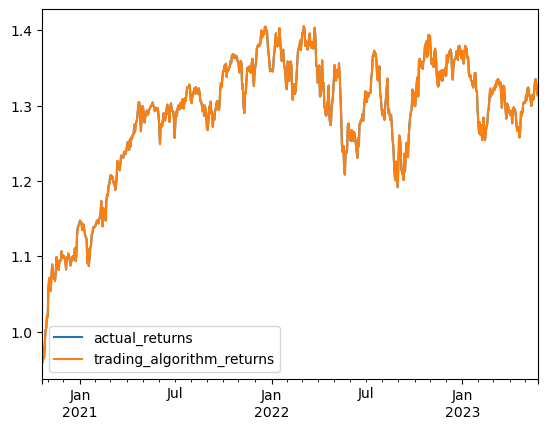

In [71]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()